<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw12/Homework12_semisupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 384 (delta 124), reused 101 (delta 67), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=ea08bf5d16f5884b0caaf67ed9e07ad355228630f574f134ace26d58e3c3741c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ognub5yt/wheels/55/59/29/0fb1c635652

In [2]:
from dul_2021.utils.hw12_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch
import torch.nn as nn
import numpy as np
import torch.autograd as autograd

# Question 1. VAT

Here we will implement [VAT](https://arxiv.org/pdf/1704.03976.pdf).

* Train labeled data with standatd cross-entropy loss

* Use vat regularization for both unlabeled and labeled data

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* ξ= 10 
* lr = 5e-4
* num_epochs = 15



**You will provide the following deliverables**


1. Over the course of training, record loss per batch.
2. After each epoch calculate accuracy on test data.

## Main class

In [5]:
class Classifier(nn.Module):
  def __init__(self, flag=True):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(3, 32, 3, 1),
                              nn.ReLU(),
                              nn.Conv2d(32, 64, 3, 2, 1),
                              nn.ReLU(),
                              nn.Conv2d(64, 64, 3, 2, 1),
                              nn.ReLU(),
                              nn.Conv2d(64, 128, 3, 2, 1),
                              nn.ReLU(),
                              nn.Conv2d(128, 128, 3, 2, 1),
                              nn.ReLU(),
                              nn.Conv2d(128, 128, 3, 2, 1),
                              nn.ReLU())
    
    self.final = nn.Sequential(nn.Flatten(), 
                               nn.Linear(128, 128), 
                               nn.ReLU(),
                               nn.Linear(128, 10))
    
    if flag:
      self.final = nn.Sequential(self.final, nn.Softmax(dim=1))
    
  def forward(self, x):
    x = self.conv(x)
    return self.final(x)

## Hyperparameters

In [25]:
labeled_batch_size = 50
all_batch_size = 200

ε = 10
n_epochs = 35

## Load data

In [26]:
train_data, test_dataset = get_data('CIFAR10')
train_data, test_dataset = SSDataset(train_data), SSDataset(test_dataset, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
from torch.utils.data import DataLoader, Subset

labeled_idx = [i for i, t in enumerate(train_data) if t[1] != -1]
labeled_subset = Subset(train_data, labeled_idx)

labeled_data = DataLoader(labeled_subset, 
                          batch_size=labeled_batch_size, 
                          shuffle=True)

all_data = DataLoader(train_data,
                      batch_size=all_batch_size,
                      shuffle=True)

test_data = DataLoader(test_dataset,
                       batch_size=256)

## Transformation

In [28]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomAffine(0, translate=(7e-2, 7e-2))])

## Define model, loss and optimizer

In [29]:
from torch.optim import Adam
from torch.nn.functional import normalize, kl_div

model = Classifier().to(device)
opt = Adam(model.parameters(), 5e-4)

nll = nn.NLLLoss()

## Train loop

In [30]:
loss_record = []
Accuracy = []

g_out = torch.ones((all_batch_size, ), device=device)
offset_shape = (all_batch_size, 3, 32, 32)

In [31]:
for epoch in range(n_epochs):
  for l_batch, a_batch in zip(labeled_data, all_data):
    
    # Batches to device
    X = transform(a_batch[0]).to(device)
    Y = transform(l_batch[0]).to(device)
    
    target = l_batch[1].to(device)
    
    # Initialize random unit vectors
    r = torch.randn(offset_shape, device=device)
    
    # L2 Normalization
    r = r.reshape((all_batch_size, -1))
    r = normalize(r)
    r = r.reshape(offset_shape)
    
    # Take D_kl
    r.requires_grad = True
    offset = model(X + ε * r)
    dist = model(X)
    dkl = -kl_div(torch.log(offset), dist, reduction='none').sum(dim=1)

    # Find argmax D_kl w.r.t. perturbation
    r = autograd.grad(dkl, r, grad_outputs=g_out)[0]
    
    # L2 Normalization
    r = r.reshape((all_batch_size, -1))
    r = normalize(r)
    r = r.reshape(offset_shape)

    # LDS
    offset = model(X + r)
    lds = kl_div(torch.log(offset), dist, reduction='batchmean')
    
    # Loss on labeled data
    clf_loss = nll(torch.log(model(Y)), target)

    loss = clf_loss + lds
    loss_record.append(loss.item())

    opt.zero_grad()
    loss.backward() 
    opt.step()

  # Compute accuracy on test dataset
  acc = 0
  for batch in test_data:
    X = batch[0].to(device)
    label = batch[1].to(device)
    
    with torch.no_grad():
      out = torch.argmax(model(X), dim=1)
    acc += (out == label).sum().item()

  Accuracy.append(acc / len(test_dataset))
  
  print(f"Epoch {epoch}")
  print(f"\t loss = {np.sum(loss_record[-100:])}")
  print(f"\t accuracy = {Accuracy[-1]}")

Epoch 0
	 loss = 173.3029146194458
	 accuracy = 0.2454
Epoch 1
	 loss = 203.71665394306183
	 accuracy = 0.2595
Epoch 2
	 loss = 197.33414351940155
	 accuracy = 0.2972
Epoch 3
	 loss = 187.2830115556717
	 accuracy = 0.336
Epoch 4
	 loss = 181.34288370609283
	 accuracy = 0.3539
Epoch 5
	 loss = 173.35428643226624
	 accuracy = 0.3832
Epoch 6
	 loss = 166.61458456516266
	 accuracy = 0.4039
Epoch 7
	 loss = 162.11484467983246
	 accuracy = 0.4035
Epoch 8
	 loss = 158.39311301708221
	 accuracy = 0.4209
Epoch 9
	 loss = 154.6311960220337
	 accuracy = 0.4432
Epoch 10
	 loss = 151.62764179706573
	 accuracy = 0.4416
Epoch 11
	 loss = 149.17859756946564
	 accuracy = 0.4499
Epoch 12
	 loss = 147.99949645996094
	 accuracy = 0.4438
Epoch 13
	 loss = 145.00837230682373
	 accuracy = 0.4719
Epoch 14
	 loss = 140.85620152950287
	 accuracy = 0.4792
Epoch 15
	 loss = 137.71346932649612
	 accuracy = 0.4782
Epoch 16
	 loss = 134.71595656871796
	 accuracy = 0.4836
Epoch 17
	 loss = 131.20035010576248
	 accura

## Result

In [32]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    return loss_record, Accuracy

Files already downloaded and verified
Files already downloaded and verified


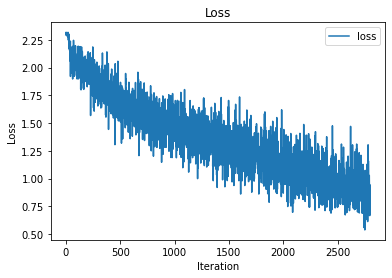

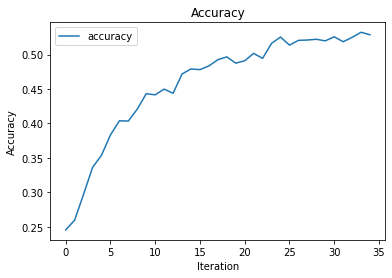

In [33]:
q12_results(q1)

# Question 2. FixMatch

Here we will implement [FixMatch](https://arxiv.org/abs/2001.07685).

* Calculate loss on weakly augmented labeled data with standatd cross-entropy loss

* Calculate loss on strongly augmented unlabeled data with standatd cross-entropy loss with pseudo-lables

* Use SimCLR transformations as strong and RandomHorizontalFlip as weak

* You can use architecture from practice

* Dataset comes as pairs `x, y`. `x` is an image from CIFAR10. `y` is a label from `[0, 10]` if datapoint is labeled and `-1` otherwise.

**Hyperparameters**

* τ = 0.7 
* λ_u = 10 (weight of unlabeled loss)
* lr = 5e-4
* num_epochs ~ 20 or more



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. After each epoch calculate accuracy on test data.

## Augmentations

In [6]:
import torchvision.transforms as transforms

strong_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=32, scale=(0.5, 1.0)),
                                       transforms.Normalize((-1,), (2.0,)),
                                       transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
                                       transforms.Normalize((0.5,), (0.5,))])

weak_transform = transforms.RandomHorizontalFlip()

## Hyperparameters

In [7]:
τ = 0.7
n_epochs = 20
batch_size = 64
μ = 7

## Load data

In [36]:
train_data, test_dataset = get_data('CIFAR10')
train_data, test_dataset = SSDataset(train_data), SSDataset(test_dataset, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [37]:
from torch.utils.data import DataLoader, Subset

labeled_idx = [i for i, t in enumerate(train_data) if t[1] != -1]
labeled_subset = Subset(train_data, labeled_idx)

labeled_data = DataLoader(labeled_subset, 
                          batch_size=batch_size, 
                          shuffle=True)

all_data = DataLoader(train_data,
                      batch_size=μ * batch_size,
                      shuffle=True)

test_data = DataLoader(test_dataset,
                       batch_size=256)

## Define model, loss and optimizer

In [38]:
from torch.optim import Adam

model = Classifier(flag=False).to(device)
opt = Adam(model.parameters(), 5e-4)

ces = nn.CrossEntropyLoss() 

## Train loop

In [39]:
from torch.nn.functional import softmax as sf
loss_record = []
Accuracy = []

In [40]:
for epoch in range(n_epochs):
  for l_batch, a_batch in zip(labeled_data, all_data):
    
    # Loss on (unlabeled + labeled) batch
    Y = weak_transform(a_batch[0]).to(device)
    logit = model(Y)
    prob_max, max_id = torch.max(sf(logit), dim=1)

    threshold_id = np.where(prob_max.cpu() > τ)[0]
    pseudo_label = max_id[threshold_id]
 
    if pseudo_label.nelement():
      Z = strong_transform(a_batch[0][threshold_id]).to(device)
      loss = ces(model(Z), pseudo_label)
    else:
      loss = 0

    # Loss on labeled batch
    X = weak_transform(l_batch[0]).to(device)
    target = l_batch[1].to(device)

    loss += ces(model(X), target)
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    loss_record.append(loss.item())

  # Compute accuracy on test dataset
  acc = 0
  for batch in test_data:
    X = batch[0].to(device)
    labels = batch[1].to(device)

    with torch.no_grad():
      idx = torch.argmax(model(X), 1)
    acc += (idx == labels).sum().item()
  
  Accuracy.append(acc / len(test_dataset))
  print(f"Epoch {epoch}")
  print(f"\t loss = {np.sum(loss_record[-100:])}")
  print(f"\t accuracy = {Accuracy[-1]}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch 0
	 loss = 155.1224924325943
	 accuracy = 0.1737
Epoch 1
	 loss = 261.52350175380707
	 accuracy = 0.2261
Epoch 2
	 loss = 250.24270260334015
	 accuracy = 0.2352
Epoch 3
	 loss = 236.2750654220581
	 accuracy = 0.262
Epoch 4
	 loss = 235.17247474193573
	 accuracy = 0.2313
Epoch 5
	 loss = 250.60419631004333
	 accuracy = 0.2464
Epoch 6
	 loss = 245.52798569202423
	 accuracy = 0.3038
Epoch 7
	 loss = 231.05594432353973
	 accuracy = 0.3307
Epoch 8
	 loss = 237.43144607543945
	 accuracy = 0.3259
Epoch 9
	 loss = 238.48575973510742
	 accuracy = 0.3312
Epoch 10
	 loss = 235.69372498989105
	 accuracy = 0.3742
Epoch 11
	 loss = 232.55876755714417
	 accuracy = 0.3796
Epoch 12
	 loss = 231.06526219844818
	 accuracy = 0.4067
Epoch 13
	 loss = 232.5511634349823
	 accuracy = 0.3677
Epoch 14
	 loss = 229.4281848669052
	 accuracy = 0.4022
Epoch 15
	 loss = 217.68480563163757
	 accuracy = 0.4086
Epoch 16
	 loss = 213.68468856811523
	 accuracy = 0.4256
Epoch 17
	 loss = 205.78843998908997
	 accurac

## Results

In [41]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 3, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """
    return loss_record, Accuracy

Files already downloaded and verified
Files already downloaded and verified


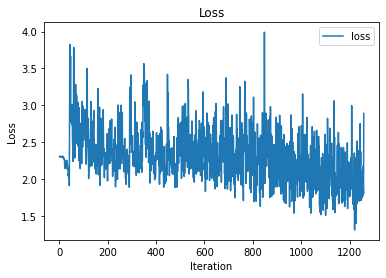

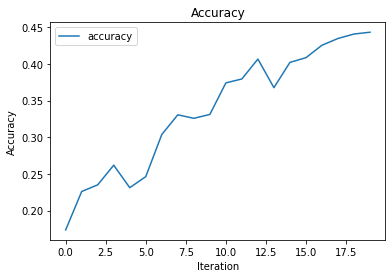

In [42]:
q12_results(q2)

# Bonus

## The probabilistic model

*(this is a short summary of the model presented in ["Semi-supervised Learning with
Deep Generative Models"](https://arxiv.org/pdf/1406.5298.pdf))*

In the semi-supervised setting, the generative model is a little more complicated than vanilla VAE. In particular, it incorporates a new variable $y$ that represents the class of a digit $x$.

\begin{align*}
& p(x, y, z) = p(x \mid y, z) p(z) p(y) \\
& p(y) = Cat(y \mid \pi_0), \pi_0 = (1/10, \dots, 1/10) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid y, z) = \prod_{i=1}^D p_i(y, z)^{x_i} (1 - p_i(y, z))^{1 - x_i}
\end{align*}

## The first part of the objective

Whenever we train a probabilistic model with partial observations, we interpret the unobserved variables as latent variables. Then we marginalize them. In this case, the loss function splits into two terms: one for observed variables (we denote the set of indices of observed labels $P$), another for unobserved.

\begin{equation}
L(X, y) = \sum_{i \notin P} \log p(x_i) + \sum_{i \in P} \log p(x_i, y_i)
\end{equation}

Again, we can't compute the exact values of marginal likelihoods and resort to variational lower bound on likelihood. To compute lower bounds, we define the following variational approximation:

\begin{align*}
& q(y, z \mid x) = q(y \mid x) q(z \mid y, x)\\
& \\
& q(y \mid x) = Cat(y \mid \pi(x))\\
& q(z \mid y, x) = \mathcal N(z \mid \mu_\phi(x, y), \operatorname{diag}\sigma^2_\phi(y, x))
\end{align*}

Using the variational approximation, we will obtain two lower bounds.

First, the ELBO for $\log p(x_i, y_i)$ for the observed variables (this one is similar to ELBO of VAE).

\begin{equation}
\log p(x, y) = \log \mathbb E_{p(z)} p(x, y \mid z) \geq \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x)}
\end{equation}

Second, the ELBO for $\log p(x_i)$ for the unobserved variables.

\begin{equation}
\log p(x) = \log \mathbb E_{p(y)} \mathbb E_{p(z \mid y)} \log p(x\mid z, y)\geq \mathbb E_{q(y \mid x)} \mathbb E_{q(z \mid y, x)} \log \frac{p(x, y \mid z) p(z)}{q(z \mid y, x) q(y \mid x)}
\end{equation}

Finally, the joint lower bound will be

\begin{equation}
\mathcal L(X, y) = \sum_{i \in P} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i)} + \sum_{i \notin P} \mathbb E_{q(y_i \mid x_i)} \mathbb E_{q(z_i \mid y_i, x_i)} \log \frac{p(x_i, y_i \mid z_i) p(z_i)}{q(z_i \mid y_i, x_i) q(y_i \mid x_i)}
\end{equation}

We will use reparametrized Monte-Carlo estimates to approximate expectation w.r.t. $z$. To approximate expectaion w.r.t. the discrete variable $y$ we will try three different options.

In [ ]:
def b(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of binary MNIST images
    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a (# of training epochs, ) numpy array accuracies on each epoch
    """